# Electrochemical SO2 sensor data preprocessing

- Pollutant: Dióxido de Enxofre
- Sensor: Alphasense SO2-B4

## Constants

### Sensors IDs

### API Constants

In [35]:
HOST = "renovar.lcqar.ufsc.br"
PORT = 8080
RAW_DATA_DIR = "data/raw-data-monit-fix-2022-2023-Diamante/"
RAW_FILE_NAME = "ISB_SO22.CSV"

SENSOR_FILE_DIR = 'data/input/'
SENSOR_NAME = 'alpha_so2_2_conc'
SENSOR_FILE_NAME = SENSOR_NAME + 'web_dataframe.csv'

### Sensor Constants

In [36]:
M = 64.066
lower_limit = 15.0
upper_limit = 20e3
t_90 = 60     # sensor takes 30 seconds to reach a value of 10e3
t_90_value = 2e3
sampling_period = 15 * 60

# Alphasense SO2 (2) Sensor Data

In [37]:
import locale
locale.setlocale(locale.LC_TIME, 'pt_BR')

'pt_BR'

In [38]:
from GetSensorDataService import GetSensorDataService

get_sensor_data_service = GetSensorDataService(HOST, PORT)
sensor_data = get_sensor_data_service.get_data_from_file(RAW_DATA_DIR+RAW_FILE_NAME, sensor_name=SENSOR_NAME)
sensor_data.head()

/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/data-pre-processing/GetSensorDataService.py:13: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['DateTime'] = (pd.to_datetime(df[date_time_col], infer_datetime_format=False, format='%d/%m/%Y/%H/%M/%S'))


,latitude,longitude,measuring,DateTime
0,-28.456899,-48.972999,65.03,2022-11-21 10:43:03
1,-28.456899,-48.972999,63.83,2022-11-21 10:58:48
2,-28.456899,-48.972999,62.47,2022-11-21 11:14:38
3,-28.456899,-48.972999,62.13,2022-11-21 11:30:22
4,-28.456899,-48.972999,60.57,2022-11-21 11:46:05


## Upload Data from File

In [39]:
import pandas as pd

df = pd.read_csv(SENSOR_FILE_DIR + SENSOR_FILE_NAME)
df.head()

,Unnamed: 0,latitude,longitude,measuring,DateTime
0,0,-28.456899,-48.972999,65.03,2022-11-21 10:43:03
1,1,-28.456899,-48.972999,63.83,2022-11-21 10:58:48
2,2,-28.456899,-48.972999,62.47,2022-11-21 11:14:38
3,3,-28.456899,-48.972999,62.13,2022-11-21 11:30:22
4,4,-28.456899,-48.972999,60.57,2022-11-21 11:46:05


### Create Sensor Dataframe as Pandas Series with a period of 15 mins

In [40]:
# Remove the first column with the indexes and save data into web dataframe
web_dataframe = df.drop(df.columns[0], axis='columns')
web_dataframe['DateTime'] = (pd.to_datetime(df['DateTime'], infer_datetime_format=True))

# Resample data with 15 mins period and create sensor dataframe
sensor_dataframe = web_dataframe.sort_values(by='DateTime', ascending=True).reset_index().drop(columns='index')
sensor_dataframe.index = sensor_dataframe['DateTime']
sensor_dataframe = sensor_dataframe.drop(columns=['DateTime'])
sensor_dataframe = sensor_dataframe.resample('15T').mean()
sensor_dataframe.head()

/var/folders/wc/_83zcrx913j1dqwg4g90kbhh0000gp/T/ipykernel_20168/2771449038.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  web_dataframe['DateTime'] = (pd.to_datetime(df['DateTime'], infer_datetime_format=True))


,latitude,longitude,measuring
DateTime,,,
2022-11-21 10:30:00,-28.456899,-48.972999,65.03
2022-11-21 10:45:00,-28.456899,-48.972999,63.83
2022-11-21 11:00:00,-28.456899,-48.972999,62.47
2022-11-21 11:15:00,NaN,NaN,NaN
2022-11-21 11:30:00,-28.456899,-48.972999,62.13


### Plot raw data

<Axes: xlabel='DateTime'>

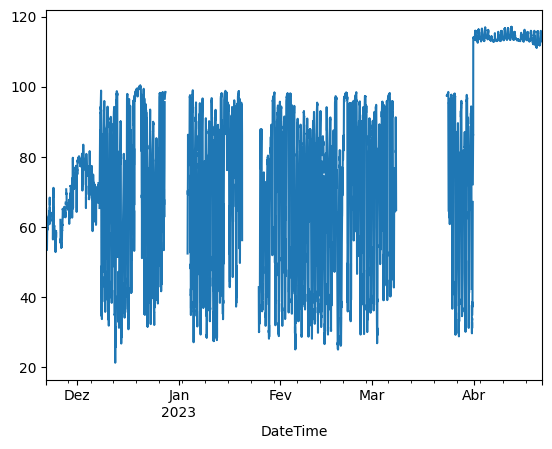

In [41]:
sensor_dataframe['measuring'].plot()

### Smooth data with a window of 4 samples, i.e.: an hour of data

<Axes: xlabel='DateTime'>

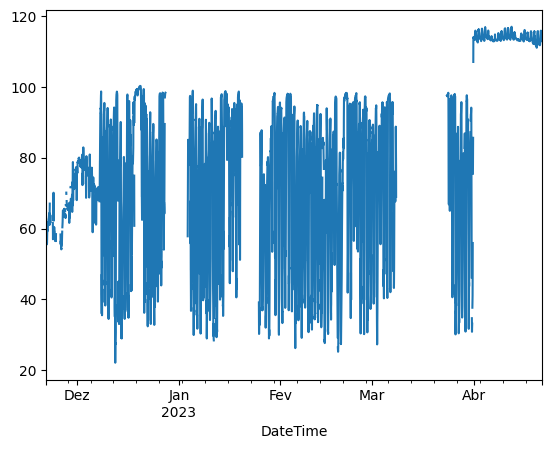

In [42]:
sensor_dataframe['raw measuring'] = sensor_dataframe['measuring']
sensor_dataframe['measuring'] = sensor_dataframe['measuring'].rolling(window=4).median()
sensor_dataframe['Hour'] = sensor_dataframe.index.hour
sensor_dataframe['measuring'].plot()

### Remove rebased data

<Axes: xlabel='DateTime'>

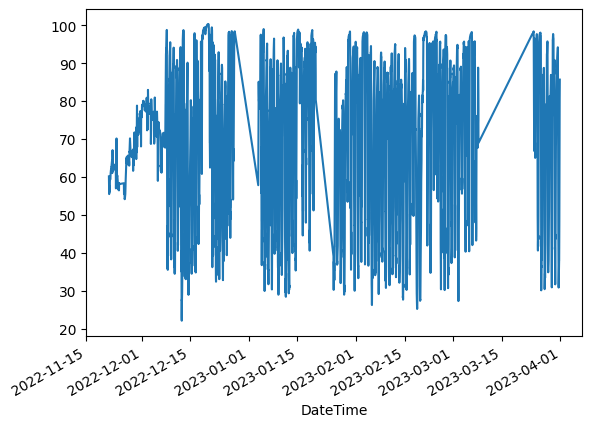

In [43]:
sensor_dataframe = sensor_dataframe[sensor_dataframe['measuring'] < 105]
sensor_dataframe['measuring'].plot()

### Convert to ug/m3

In [44]:
sensor_dataframe['value'] = sensor_dataframe['measuring'].map(lambda v: 0.0409*v*M)

## Tag data
Apply tags to the data according to the quality control processes described above

In [45]:
sensor_dataframe['Tag'] = 'VALID'

#### Tag data during stabilizing period
AQMesh recomends to considering the first two days after installation as a period for stabilization. In our case, a period of seven days was selected in order to remove outliers candidates detected during that period. For that purpose we detect the first 7 days of uninterrupted measurements

,latitude,longitude,measuring,raw measuring,Hour,value,Tag
DateTime,,,,,,,
2022-11-21 12:15:00,-28.456899,-48.972999,60.140,59.21,12,157.584806,STABILIZING
2022-11-21 12:30:00,-28.456899,-48.972999,59.460,58.56,12,155.803002,STABILIZING
2022-11-21 12:45:00,-28.456899,-48.972999,58.885,57.30,12,154.296330,STABILIZING
2022-11-21 13:00:00,-28.456899,-48.972999,57.930,56.04,13,151.793944,STABILIZING
2022-11-21 13:15:00,-28.456899,-48.972999,56.670,54.96,13,148.492367,STABILIZING


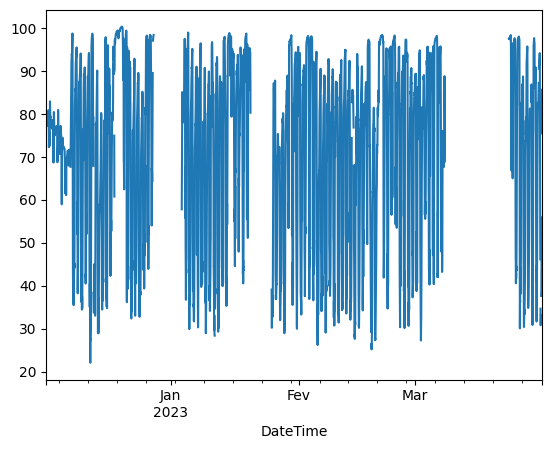

In [46]:
# Identify consecutive measurements (15 mins between each)
consecutive_periods = sensor_dataframe.index.to_series().diff().dt.seconds == 900

# Select the first seven days of consecutive measurements (96 = 24 * 60 mins / 15 mins, amount of 15 mins periods in a day)
last_stabilizing_index = sensor_dataframe[consecutive_periods].head(96 * 7).index[-1] # 7 days
sensor_dataframe.loc[sensor_dataframe.index[0]:last_stabilizing_index,'Tag'] = 'STABILIZING'
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']['measuring'].resample('15T').mean().plot()
sensor_dataframe.head()

#### Tag values that are missing, are greater than sensor span or are lower than sensor resolution

The upper limit was too high that affected the graph resolution, therefore it is not plotted

<Axes: xlabel='DateTime'>

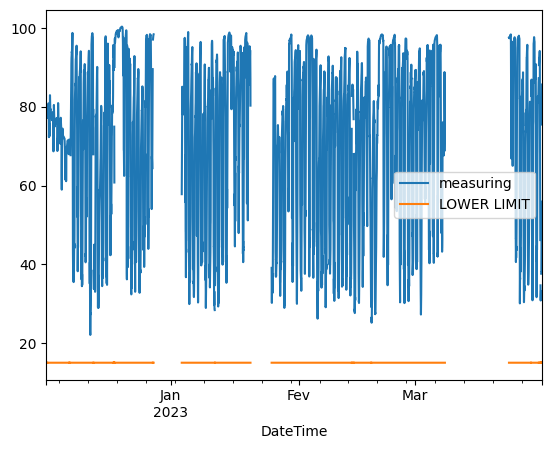

In [47]:
sensor_dataframe['UPPER LIMIT'] = upper_limit
sensor_dataframe['LOWER LIMIT'] = lower_limit
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['measuring', 'LOWER LIMIT']].resample('15T').mean().plot()

In [48]:
import numpy as np
from SensorDataAnalysisService import SensorDataAnalysisService as sensor_analysis

def tag_by_sensor_limits(value, tag, lower_limit, upper_limit):
 if (tag != 'VALID'): return tag
 return sensor_analysis.get_tags_from_series(value=value,
                                             lower_limit=lower_limit,
                                             upper_limit=upper_limit)

sensor_dataframe['Tag'] = (sensor_dataframe[['measuring', 'Tag']]
                                        .apply(lambda df: tag_by_sensor_limits(value=df[0], tag=df[1],
                                                                              lower_limit=lower_limit,
                                                                              upper_limit=upper_limit),
                                                axis=1))

#### Plot valid data after removing samples bellow lower limit

Text(0, 0.5, 'Concentração (ppb)')

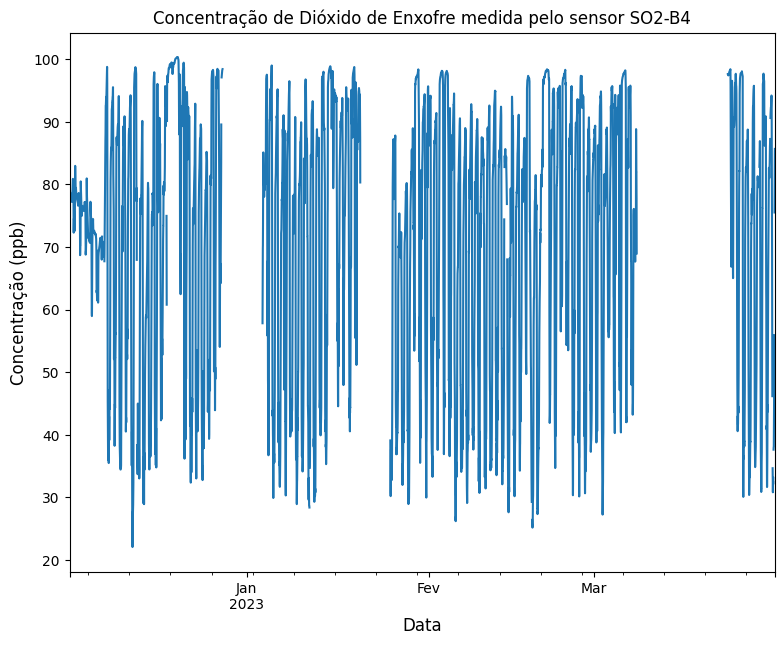

In [49]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(1.3*7,7))
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']['measuring'].rename('Concentração de Dióxido de Enxofre').resample('15T').mean().plot()
plt.title('Concentração de Dióxido de Enxofre medida pelo sensor SO2-B4')
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Concentração (ppb)', fontsize=12)

## Change point Analysis

### Change point analysis of 15 mins data

In [50]:
import ruptures as rpt

series = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']['measuring']
signal = np.array(series).reshape(-1, 1)
algo = rpt.Pelt(model="rbf", jump=50, min_size=100).fit(signal=signal)
result = algo.predict(pen=10)
result

[300,
 550,
 1150,
 1300,
 1550,
 1750,
 1900,
 2250,
 2600,
 3500,
 3650,
 3800,
 4100,
 4350,
 4500,
 4850,
 5000,
 6200,
 6300,
 6500,
 6600,
 7000,
 7500,
 7600,
 7950,
 8050,
 8300,
 8788]

In [51]:
change_point_index = series[[x - 1 for x in result]].index
sensor_dataframe['CHANGE POINT'] = False
sensor_dataframe['CHANGE POINT'].loc[change_point_index] = True

/var/folders/wc/_83zcrx913j1dqwg4g90kbhh0000gp/T/ipykernel_20168/717246363.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_dataframe['CHANGE POINT'].loc[change_point_index] = True


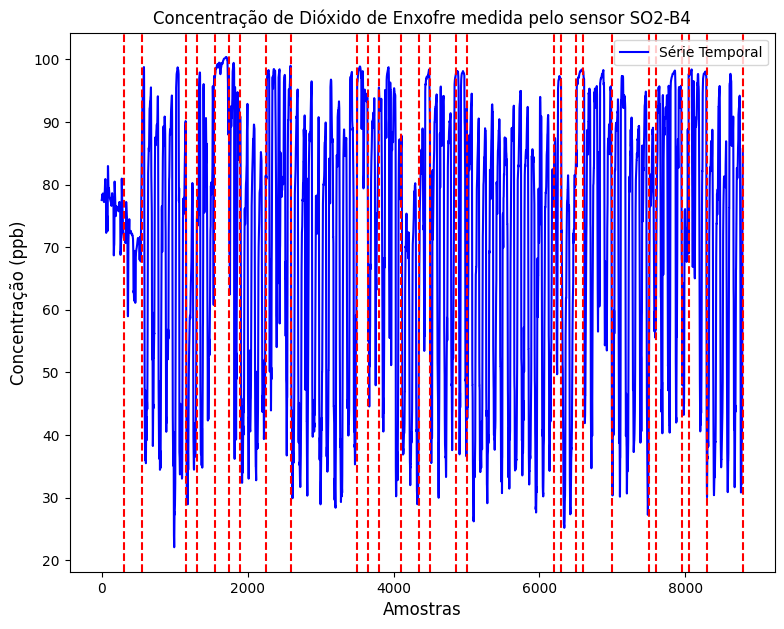

In [52]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(1.3*7,7))
plt.plot(signal, label='Série Temporal', color='blue')
plt.title('Concentração de Dióxido de Enxofre medida pelo sensor SO2-B4')
ax.set_xlabel('Amostras', fontsize=12)
ax.set_ylabel('Concentração (ppb)', fontsize=12)

# Plot change points
for point in result:
    plt.axvline(x=point, color='red', linestyle='--')

# Show the plot
plt.legend()
plt.show()

#### Data Tag contabilization

In [53]:
tags = ['MISSING','LTLL', 'GTUL', 'STABILIZING', 'BADSPIKE', 'VALID', 'REBASE']
data_contabilization = sensor_analysis.count_tags(tags, sensor_dataframe)
data_contabilization

,#,%
MISSING,0,0.0
LTLL,0,0.0
GTUL,0,0.0
STABILIZING,697,7.348445
BADSPIKE,0,0.0
VALID,8788,92.651555
REBASE,0,0.0
TOTAL,9485,100.0


## Analyse valid data

The graph shows the time series of the valid data, box plots of the data grouped by hour of the day, and histogram of the data.

In [54]:
valid_dataframe = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'].drop(columns=['Tag'])

### Smooth data with a window of 4 samples, i.e.: an hour of data

<Axes: xlabel='DateTime'>

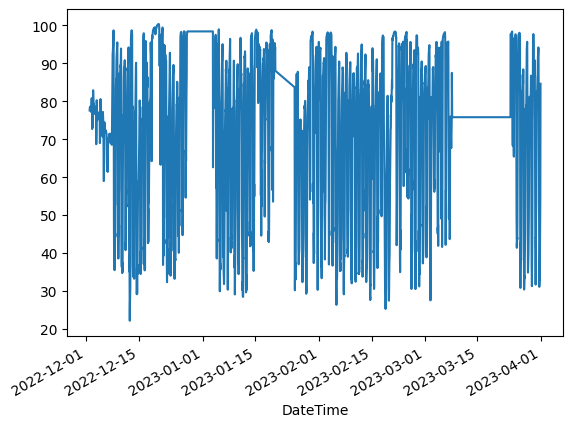

In [55]:
valid_dataframe['raw measuring'] = valid_dataframe['measuring']
valid_dataframe['measuring'] = valid_dataframe['measuring'].rolling(window=4).median()
valid_dataframe['measuring'].plot()

### Analyse data

/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/data-pre-processing/SensorDataAnalysisService.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['Hour'].astype('int64')


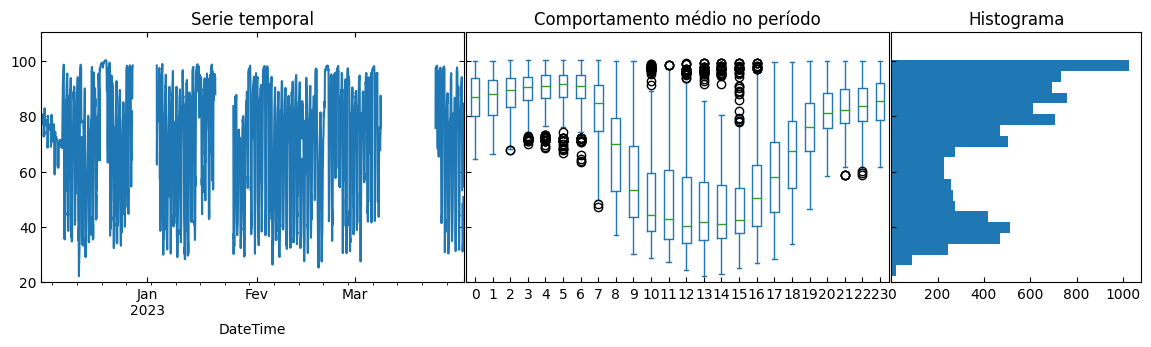

In [56]:
valid_dataframe = valid_dataframe.resample('15T').mean()
sensor_analysis.plot_box_hist(df=valid_dataframe, bins=20)

### Calculate quantiles

We calculated the 1% and 99 % quantiles of every hour of the day. The values greater outside the 1 % - 99 % where tagged as Greater that Quantile 99 (GTQTLE99) and Lower than Quantile 1 (LTQTLE01)

<Axes: xlabel='DateTime'>

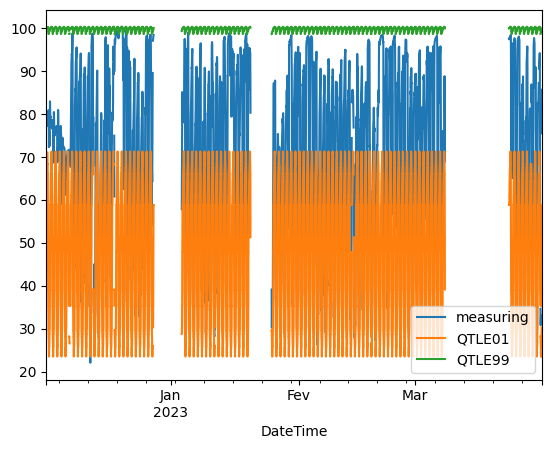

In [57]:
import numpy as np

global_qtle_01 = valid_dataframe.pivot(columns='Hour')['measuring'].quantile(q=0.01, axis='index', interpolation='lower').dropna()
global_qtle_99 = valid_dataframe.pivot(columns='Hour')['measuring'].quantile(q=0.99, axis='index', interpolation='higher').dropna()
sensor_dataframe['QTLE01'] = sensor_dataframe['Hour'].map(lambda hr: global_qtle_01[hr] if (not np.isnan(hr)) else np.nan)
sensor_dataframe['QTLE99'] = sensor_dataframe['Hour'].map(lambda hr: global_qtle_99[hr] if (not np.isnan(hr)) else np.nan)
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['measuring', 'QTLE01', 'QTLE99']].resample('15T').mean().plot()

### Tag data according to quantiles

In [58]:
sensor_dataframe['Tag'] = (sensor_dataframe[['Tag', 'measuring', 'QTLE01', 'QTLE99']]
                           .apply(lambda df: sensor_analysis.tag_by_quantiles(current_tag=df[0],
                                                                              value=df[1],
                                                                              quantile_01=df[2],
                                                                              quantile_99=df[3]),
                                axis=1))
tags = ['MISSING','LTLL', 'GTUL', 'BADSPIKE', 'VALID', 'LTQTLE01', 'GTQTLE99']
data_contabilization = sensor_analysis.count_tags(tags, sensor_dataframe)
data_contabilization

,#,%
MISSING,0,0.0
LTLL,0,0.0
GTUL,0,0.0
BADSPIKE,0,0.0
VALID,8599,90.658935
LTQTLE01,107,1.128097
GTQTLE99,82,0.864523
TOTAL,9485,100.0


#### Plot valid data

<Axes: xlabel='DateTime'>

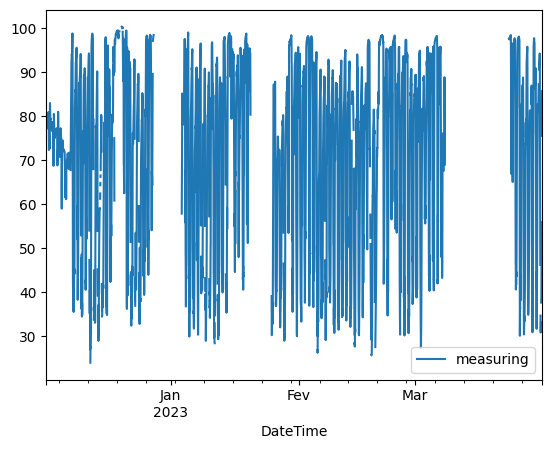

In [59]:
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['measuring']].resample('15T').mean().plot()

#### Analyse data after removing quantiles

/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/data-pre-processing/SensorDataAnalysisService.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['Hour'].astype('int64')


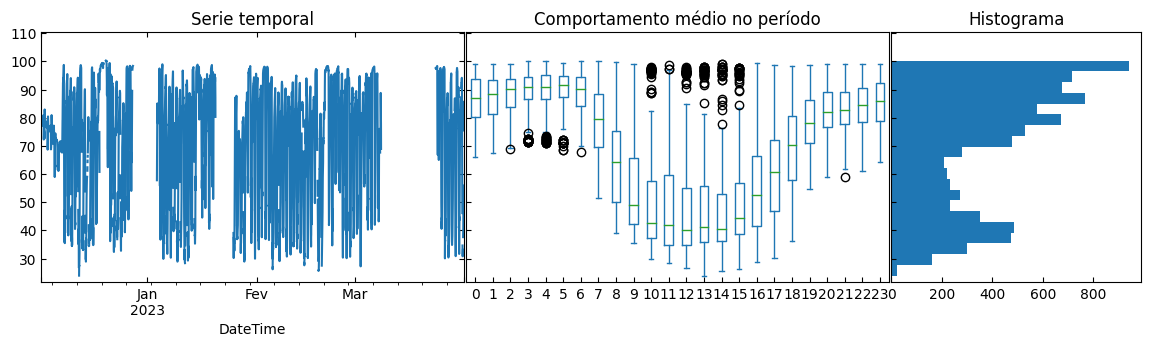

In [60]:
valid_dataframe = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'].drop(columns=['Tag']).resample('15T').mean()
sensor_analysis.plot_box_hist(df=valid_dataframe, bins=20)

## Analyse data derivatives

Analyse the derivatives of the data for removing abrupt changes in the data (BADSPIKE)

#### Tag values with derivatives faster than sensor response time
The value of 200 ppb was selected based on the maximum derivative found in the reference data. The maximum derivative (with measuring period of 1 hour) found was 200 ppb. Therefore, a maximum of 200 ppb was considered appropriate for a 15 mins period.

<Axes: xlabel='DateTime'>

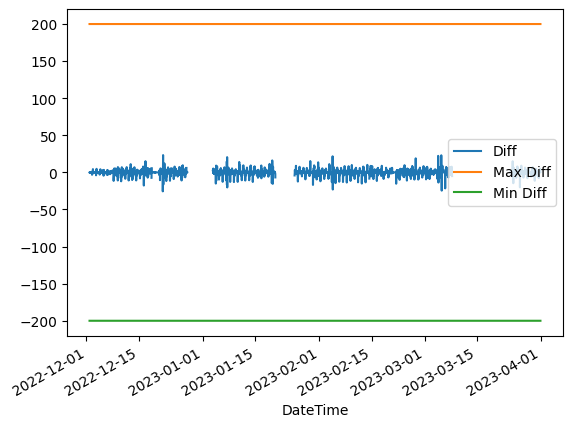

In [61]:
max_diff_value = 200
sensor_dataframe['Diff'] = sensor_dataframe['measuring'].resample('15T').mean().diff()
sensor_dataframe['Max Diff'] = max_diff_value
sensor_dataframe['Min Diff'] = -max_diff_value
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['Diff', 'Max Diff', 'Min Diff']].plot()

#### Plot data derivatives vs data

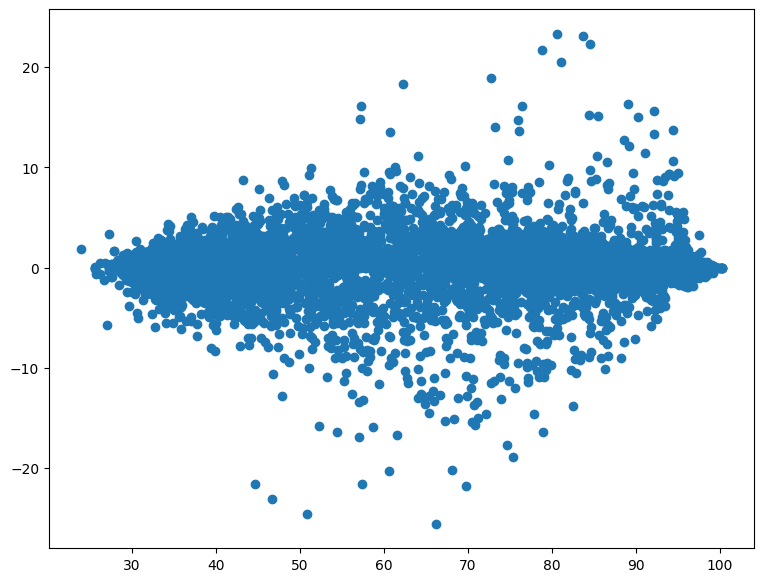

In [62]:
import matplotlib.pyplot as plt

valid_dataframe = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']
fig = plt.figure(figsize=(1.3*7,7))
plt.scatter(valid_dataframe['measuring'], valid_dataframe['Diff'])

#### Plot valid data

Text(0, 0.5, 'Concentração (ppb)')

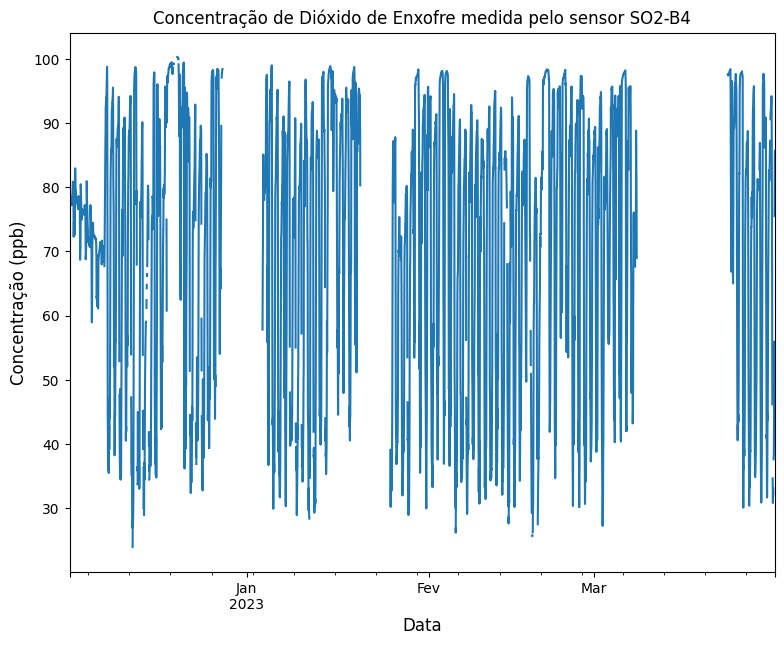

In [63]:
fig, ax = plt.subplots(figsize=(1.3*7,7))
(sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']['measuring']
 .rename('Concentração de Dióxido de Enxofre').resample('15T').mean().plot())
plt.title('Concentração de Dióxido de Enxofre medida pelo sensor SO2-B4')
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Concentração (ppb)', fontsize=12)

/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/data-pre-processing/SensorDataAnalysisService.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['Hour'].astype('int64')


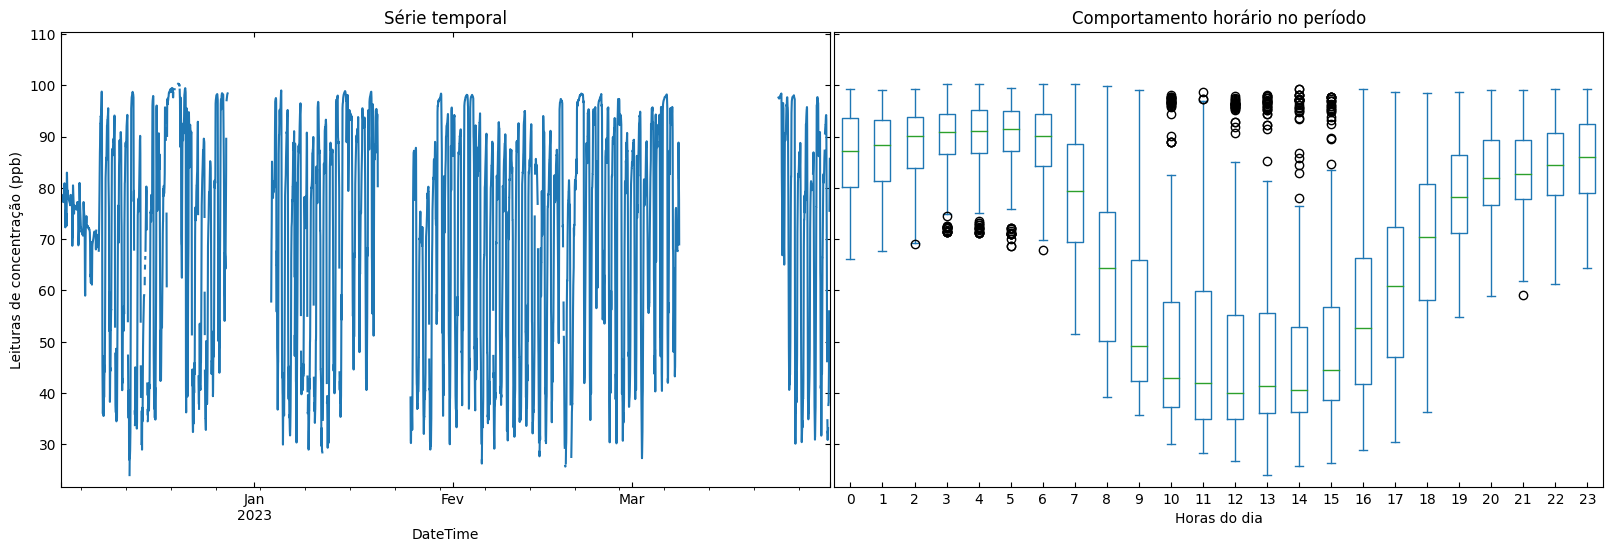

In [64]:
valid_dataframe = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'].drop(columns=['Tag']).resample('15T').mean()
sensor_analysis.plot_box(df=valid_dataframe)

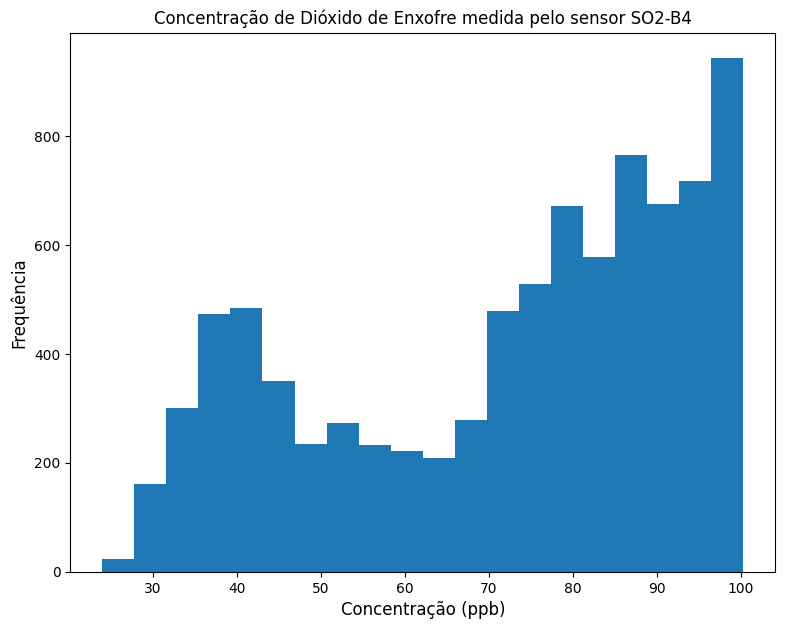

In [65]:
fig, ax = plt.subplots(figsize=(1.3*7,7))
(sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']['measuring'].rename('Concentração de Dióxido de Enxofre')
 .resample('15T').mean().hist(bins=20))
plt.title('Concentração de Dióxido de Enxofre medida pelo sensor SO2-B4')
ax.set_xlabel('Concentração (ppb)', fontsize=12)
ax.set_ylabel('Frequência', fontsize=12)
ax.grid(False)

## Resample valid data to 1 HR

<Axes: xlabel='DateTime'>

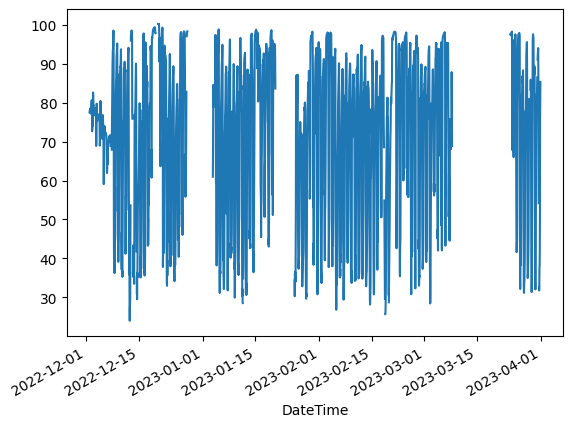

In [51]:
resampled_dataframe = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'].drop(columns=['Tag']).resample('H').mean()
resampled_dataframe['Hour'] = resampled_dataframe.index.hour
resampled_dataframe['Count'] = (valid_dataframe['measuring'].resample('H').count())
resampled_dataframe['Std'] = (valid_dataframe['measuring'].resample('H').std())
resampled_dataframe.index = resampled_dataframe.index.map(lambda t: t.replace(minute=30, second=0))
resampled_dataframe['measuring'].plot()

#### Tag hourly data according to the number of samples in an hour
At least 3 samples must be valid in an hour (75 %) for the hourly data be considered as valid

<Axes: xlabel='DateTime'>

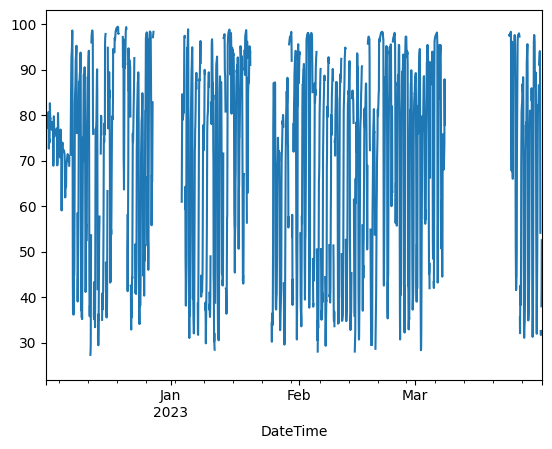

In [52]:
resampled_dataframe['Tag'] = (resampled_dataframe['Count']
                                .map(lambda c: 'VALID' if c >= 3 else 'LOWSAMPLES'))
resampled_dataframe[resampled_dataframe['Tag'] == 'VALID']['measuring'].resample('H').mean().plot()

#### Valid data contabilization

In [53]:
tags = ['LOWSAMPLES','VALID'] 
data_contabilization = sensor_analysis.count_tags(tags, resampled_dataframe)
data_contabilization

,#,%
LOWSAMPLES,787,27.316904
VALID,2094,72.683096
TOTAL,2881,100.0


# Save Data

In [54]:
import os

output_directory_path = 'data/output/'
processing_directory_path = '../data-processing/input/'
valid_1HR_filename = '_valid_data_1HR.csv'
valid_filename = '_valid_data.csv'
dataframe_filename = '_dataframe.csv'
dataframe_1HR_filename = '_dataframe_1hr.csv'

valid_1HR_file_path_output = output_directory_path + SENSOR_NAME + valid_1HR_filename
valid_file_path_output = output_directory_path + SENSOR_NAME + valid_filename

dataframe_path_1HR_output = output_directory_path + SENSOR_NAME + dataframe_1HR_filename
dataframe_path_output = output_directory_path + SENSOR_NAME + dataframe_filename

valid_processing_1HR_file_path = processing_directory_path + SENSOR_NAME + valid_1HR_filename
valid_processing_file_path = processing_directory_path + SENSOR_NAME + valid_filename

processing_dataframe_path_1HR = processing_directory_path + SENSOR_NAME + dataframe_1HR_filename
processing_dataframe_path = processing_directory_path + SENSOR_NAME + dataframe_filename

if not os.path.exists(output_directory_path):
    os.makedirs(output_directory_path)

if not os.path.exists(processing_directory_path):
    os.makedirs(processing_directory_path)

sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['measuring', 'value']].to_csv(valid_file_path_output)
resampled_dataframe[resampled_dataframe['Tag'] == 'VALID'][['measuring', 'value']].to_csv(valid_1HR_file_path_output)
sensor_dataframe.to_csv(dataframe_path_output)
resampled_dataframe.to_csv(dataframe_path_1HR_output)

sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['measuring', 'value']].to_csv(valid_processing_file_path)
resampled_dataframe[resampled_dataframe['Tag'] == 'VALID'][['measuring', 'value']].to_csv(valid_processing_1HR_file_path)
sensor_dataframe.to_csv(processing_dataframe_path)
resampled_dataframe.to_csv(processing_dataframe_path_1HR)